In [2]:
 ! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soufianefartit","key":"55f16ee3eba199cb58ee73def53549fc"}'}

In [5]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
imoore/60k-stack-overflow-questions-with-quality-rate               60k Stack Overflow Questions with Quality Rating     21MB  2020-09-11 18:28:28            989  
tunguz/us-elections-dataset                                         US Elections Dataset                                  7MB  2020-09-12 16:16:48           1811  
ihelon/lego-minifigures-classification                              LEGO Minifigures Classification                      16MB  2020-09-15 08:40:08            920  
anikannal/solar-power-generation-data                               Solar Power Generation Data                           2MB  2020-08-18 15:52:03           3356  
douglaskgaraujo/

In [11]:
! kaggle datasets download -d 'franciscoescobar/satellite-images-of-water-bodies'

 98% 241M/247M [00:05<00:00, 43.1MB/s]
100% 247M/247M [00:05<00:00, 47.6MB/s]


In [12]:
! unzip satellite-images-of-water-bodies.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1823.jpg  
  inf

# UTILS

In [70]:
import numpy as np
import cv2

def preprocess_imgs(img, mask):
    
    # change channels
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # normalize
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # resize
    img = cv2.resize(img, (128, 128))
    mask = cv2.resize(mask, (128, 128))
    
    return img, mask

def read_img(img_num):
    
    img_path = "Water Bodies Dataset/Images/water_body_"+ img_num +".jpg"
    mask_path = "Water Bodies Dataset/Masks/water_body_"+ img_num +".jpg"

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    return img, mask

def get_img_nums():
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir("Water Bodies Dataset/Masks/") if isfile(join("Water Bodies Dataset/Masks/", f))]
    return [x[11:-4] for x in onlyfiles]


def load_data(N=None):
    imgs = []
    masks = []
    
    if N :
      for i in get_img_nums()[:N] :
          img, mask = read_img(i)
          img, mask = preprocess_imgs(img, mask)
          
          imgs.append(img)
          masks.append(mask)
    else :
      for i in get_img_nums() :
          img, mask = read_img(i)
          img, mask = preprocess_imgs(img, mask)
          
          imgs.append(img)
          masks.append(mask)
    
    return np.array(imgs), np.array(masks)


# Model DEFINITION

In [34]:
# IS GPU WORKING ?
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# WHICH GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [64]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute, Concatenate, Input
from tensorflow.keras.models import Sequential, Model

class AutoEncoder:
    def __init__(self):
        self.latent_size = 0
        self.n_labels = 2
        self.img_h = 128
        self.img_w = 128
        self.encoding_layers = []
        self.decoding_layers = []
        self.encoder = Sequential()
        self.decoder = Sequential()
        
    def build_autoencoder(self):
        print('Building model...', end='\n')
        self.build_encoder()
        self.build_decoder()
        self.input = Input((128, 128, 3), batch_size=None)
        self.latent = self.encoder(self.input)
        self.output = self.decoder(self.latent)
        self.autoencoder = Model(self.input, self.output)
        
        # Compile
        print('Compiling model...', end='\n')
        self.autoencoder.compile(loss="mse", optimizer='Adam')
        
    def build_encoder(self):
        self.encoding_layers = self.conv_block(1, 3, 128, 128)+self.conv_block(128, 3)+self.conv_block(256, 3)+self.conv_block(512, 3)
        for layer in self.encoding_layers:
            self.encoder.add(layer)
        
    def build_decoder(self):
        self.decoding_layers = self.deconv_block(512, 3)+self.deconv_block(256, 3)+self.deconv_block(128, 3)+self.deconv_block(64, 3, 1, 'sigmoid')
        #self.decoding_layers = self.deconv_block(512, 3)+self.deconv_block(256, 3)+self.deconv_block(128, 3)+self.deconv_block(64, 3, 2, 'sigmoid')
        #self.decoding_layers = self.deconv_block(64, 3)+self.deconv_block(128, 3)+self.deconv_block(256, 3)+self.deconv_block(512, 3, 2)
        for layer in self.decoding_layers:
            self.decoder.add(layer)
        self.decoder.add(Reshape((self.img_h, self.img_w)))
        #self.decoder.add(Reshape((self.n_labels, self.img_h, self.img_w)))
        #self.decoder.add(Permute((2, 3, 1)))
        #self.decoder.add(Activation('sigmoid'))
    
    def conv_block(self, filter_num, kernel, img_w=None, img_h=None):
        block_list = []
        
        if img_w and img_h :
            block_list.append(Conv2D(3*filter_num, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 3)))
        else :
            block_list.append(Conv2D(3*filter_num, (kernel, kernel), padding='same'))    
        block_list.append(BatchNormalization())
        block_list.append(Activation('relu'))
        
        block_list.append(Conv2D(filter_num, (kernel, kernel), padding='same'))
        block_list.append(BatchNormalization())
        block_list.append(Activation('relu'))
        
        block_list.append(MaxPooling2D())
        
        return block_list
    
    def deconv_block(self, filter_num, kernel, n_labels=None, last_activation=None):
        block_list = []
        
        block_list.append(UpSampling2D())
        
        block_list.append(Conv2D(filter_num, (kernel, kernel), padding='same'))
        block_list.append(BatchNormalization())
        block_list.append(Activation('relu'))
        
        block_list.append(Conv2D(filter_num, (kernel, kernel), padding='same'))
        block_list.append(BatchNormalization())
        block_list.append(Activation('relu'))
        
        if n_labels :
            block_list.append(Conv2D(n_labels, (kernel, kernel), padding='same'))
        else :
            block_list.append(Conv2D(filter_num, (kernel, kernel), padding='same'))
        block_list.append(BatchNormalization())
        if last_activation :
            block_list.append(Activation(last_activation))
        else :
            block_list.append(Activation('relu'))
        
        return block_list
    

# TRAINING

In [65]:
a = AutoEncoder()
a.build_autoencoder()

Building model...
Compiling model...


In [71]:
imgs, masks = load_data()

In [82]:
imgs_train, imgs_test = imgs[:2000], imgs[2000:]
masks_train, masks_test = masks[:2000], masks[2000:]
imgs_train.shape, masks_test.shape

((2000, 128, 128, 3), (841, 128, 128))

In [77]:
history = a.autoencoder.fit(imgs_train, masks_train, epochs=2000, verbose=0)
plt.plot(history.history['loss'])

KeyboardInterrupt: ignored

In [78]:
a.autoencoder.save('autoencoder')
a.encoder.save('encoder')
a.decoder.save('decoder')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: autoencoder/assets
INFO:tensorflow:Assets written to: encoder/assets
INFO:tensorflow:Assets written to: decoder/assets


# TRAIN DATASET

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


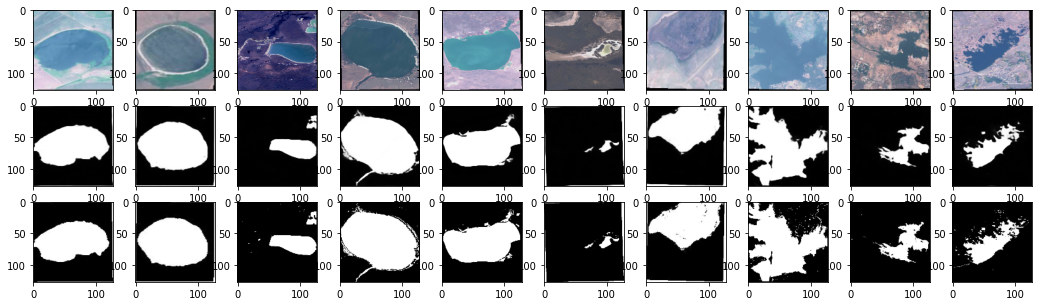

In [79]:
preds_train = a.autoencoder.predict(imgs_train)
fig, ax = plt.subplots(figsize=(18, 5))
plt.subplot(3,10,1)
for i in range(1,11):
    plt.subplot(3,10,i)
    plt.imshow(imgs_train[i-1], cmap='gray')
    plt.subplot(3,10,10+i)
    plt.imshow(preds_train[i-1], cmap='gray')
    plt.subplot(3,10,20+i)
    plt.imshow(masks_train[i-1], cmap='gray')


# TEST DATA SET

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


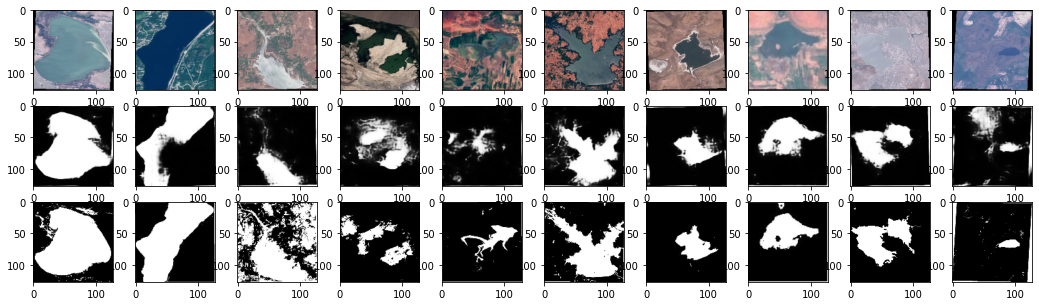

In [85]:
k=2
preds_test = a.autoencoder.predict(imgs_test)
fig, ax = plt.subplots(figsize=(18, 5))
plt.subplot(3,10,1)
for i in range(1,11):
    plt.subplot(3,10,i)
    plt.imshow(imgs_test[k*10+i-1], cmap='gray')
    plt.subplot(3,10,10+i)
    plt.imshow(preds_test[k*10+i-1], cmap='gray')
    plt.subplot(3,10,20+i)
    plt.imshow(masks_test[k*10+i-1], cmap='gray')